# Time-Series Analysis using LSTM: Prothom Alo

## Highlights

* Dataset: Prothom Alo 2021 Dataset.
* Training Period: 2021-04-24 to 2021-06-19
* Test/Validation Period: 2021-06-20 to 2021-06-27

Author: Sumaia Parveen Shupti

Created on: 07/07/2021

Updated on: 07/10/2021



In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from datetime import datetime, timedelta
import warnings
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
#import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from keras.callbacks import EarlyStopping, ModelCheckpoint

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(1)

### Load & Preprocess Dataset

In [2]:
df1 = pd.read_csv('../input/prothom-alo-20192021/prothom_alo_2021.csv')
df1 = df1[['date_of_incident', 'time_of_incident', 'published-time',
       'incident_type', 'location', 'death_count',
       'type_of_vehicle1', 'type_of_vehicle2']]

df1.loc[1, 'time_of_incident'] = '20:00'
df1["time_of_incident"] = pd.to_datetime(df1["time_of_incident"], format='%H:%M').dt.time

df1['date_of_incident'] = pd.to_datetime(df1['date_of_incident'])
df1 = df1.reset_index(drop = True).set_index('date_of_incident').resample('1D').sum().reset_index()
df = df1.copy()
df.columns = ['Period', 'death_count']
df

,Period,death_count
0,2021-01-01,4.0
1,2021-01-02,0.0
2,2021-01-03,7.0
3,2021-01-04,0.0
4,2021-01-05,0.0
...,...,...
173,2021-06-23,3.0
174,2021-06-24,2.0
175,2021-06-25,0.0
176,2021-06-26,2.0


In [3]:
df.dtypes

Period         datetime64[ns]
death_count           float64
dtype: object

### Splitting into Train & Test Sets

In [4]:
start_ = df.Period.max()
end_ = df.Period.min()

test_end = df.Period.max()
test_start = df.Period.max() - timedelta(days = 7)

train_end = test_start - timedelta(days = 1)
train_start = train_end - timedelta(days = 57)

print('Dataset Start Date: {}'.format(start_))
print('Dataset End Date: {}'.format(end_))
print (' ')
print('Train Set Start Date: {}'.format(train_start))
print('Train Set End Date: {}'.format(train_end))
print (' ')
print('Test Set Start Date: {}'.format(test_start))
print('Test Set End Date: {}'.format(test_end))
print (' ')

Dataset Start Date: 2021-06-27 00:00:00
Dataset End Date: 2021-01-01 00:00:00
 
Train Set Start Date: 2021-04-23 00:00:00
Train Set End Date: 2021-06-19 00:00:00
 
Test Set Start Date: 2021-06-20 00:00:00
Test Set End Date: 2021-06-27 00:00:00
 


In [5]:
mask = (df.Period > train_start) & (df.Period <= train_end)
train = df.loc[mask]

mask = (df.Period >= test_start) & (df.Period <= test_end)
test = df.loc[mask]

In [6]:
train.tail()

,Period,death_count
165,2021-06-15,0.0
166,2021-06-16,0.0
167,2021-06-17,0.0
168,2021-06-18,15.0
169,2021-06-19,10.0


In [7]:
test.head()

,Period,death_count
170,2021-06-20,2.0
171,2021-06-21,0.0
172,2021-06-22,1.0
173,2021-06-23,3.0
174,2021-06-24,2.0


In [8]:
d = pd.concat([train, test])
d = d.reset_index(drop = True)
d

,Period,death_count
0,2021-04-24,2.0
1,2021-04-25,0.0
2,2021-04-26,1.0
3,2021-04-27,0.0
4,2021-04-28,3.0
...,...,...
60,2021-06-23,3.0
61,2021-06-24,2.0
62,2021-06-25,0.0
63,2021-06-26,2.0


### Transform the data into a time series problem

In [9]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### We will use the present day and the last 3 days data to forecast 1 day's results ahead

In [10]:
window = 3
lag = 1
series = series_to_supervised(d.drop('Period', axis=1), window=window, lag=lag)
series

,death_count(t-3),death_count(t-2),death_count(t-1),death_count(t),death_count(t+1)
3,2.0,0.0,1.0,0.0,3.0
4,0.0,1.0,0.0,3.0,0.0
5,1.0,0.0,3.0,0.0,4.0
6,0.0,3.0,0.0,4.0,0.0
7,3.0,0.0,4.0,0.0,5.0
...,...,...,...,...,...
59,10.0,2.0,0.0,1.0,3.0
60,2.0,0.0,1.0,3.0,2.0
61,0.0,1.0,3.0,2.0,0.0
62,1.0,3.0,2.0,0.0,2.0


In [11]:
lag_size = 1 

# Label
labels_col = 'death_count(t+%d)' % lag_size
labels = series[[labels_col]]
series = series.drop(labels_col, axis=1)
series

,death_count(t-3),death_count(t-2),death_count(t-1),death_count(t)
3,2.0,0.0,1.0,0.0
4,0.0,1.0,0.0,3.0
5,1.0,0.0,3.0,0.0
6,0.0,3.0,0.0,4.0
7,3.0,0.0,4.0,0.0
...,...,...,...,...
59,10.0,2.0,0.0,1.0
60,2.0,0.0,1.0,3.0
61,0.0,1.0,3.0,2.0
62,1.0,3.0,2.0,0.0


In [12]:
labels

,death_count(t+1)
3,3.0
4,0.0
5,4.0
6,0.0
7,5.0
...,...
59,3.0
60,2.0
61,0.0
62,2.0


In [13]:
X_train = series[:len(train)- window]
X_train

,death_count(t-3),death_count(t-2),death_count(t-1),death_count(t)
3,2.0,0.0,1.0,0.0
4,0.0,1.0,0.0,3.0
5,1.0,0.0,3.0,0.0
6,0.0,3.0,0.0,4.0
7,3.0,0.0,4.0,0.0
8,0.0,4.0,0.0,5.0
9,4.0,0.0,5.0,5.0
10,0.0,5.0,5.0,2.0
11,5.0,5.0,2.0,0.0
12,5.0,2.0,0.0,0.0


In [14]:
Y_train = labels[:len(train)- window]
Y_train

,death_count(t+1)
3,3.0
4,0.0
5,4.0
6,0.0
7,5.0
8,5.0
9,2.0
10,0.0
11,0.0
12,0.0


In [15]:
X_valid = series[len(train)- window:]
X_valid

,death_count(t-3),death_count(t-2),death_count(t-1),death_count(t)
57,0.0,15.0,10.0,2.0
58,15.0,10.0,2.0,0.0
59,10.0,2.0,0.0,1.0
60,2.0,0.0,1.0,3.0
61,0.0,1.0,3.0,2.0
62,1.0,3.0,2.0,0.0
63,3.0,2.0,0.0,2.0


In [16]:
Y_valid = labels[len(train)- window:]
Y_valid

,death_count(t+1)
57,0.0
58,1.0
59,3.0
60,2.0
61,0.0
62,2.0
63,4.0


In [17]:
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)

print('Train labels shape', Y_train.shape)
print('Validation labels shape', Y_valid.shape)

Train set shape (54, 4)
Validation set shape (7, 4)
Train labels shape (54, 1)
Validation labels shape (7, 1)


### Data Preprocess

* Reshape from [samples, timesteps] into [samples, timesteps, 1].

**Note: timestep = window + lag**

* In our case, window = 3, lag = 1.

In [18]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (54, 4, 1)
Validation set shape (7, 4, 1)


### Model Development: LSTM

In [19]:
epochs = 100
batch = 4
lr = 0.0003
adam = optimizers.Adam(lr)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

In [20]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mae', optimizer=adam)
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [21]:
%%time
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=1, callbacks=[es, mcp])

Epoch 1/100
2/2 [==============================] - 2s 646ms/step - loss: 1.6498 - val_loss: 1.7146

Epoch 00001: val_loss improved from inf to 1.71462, saving model to weights.h5
Epoch 2/100
2/2 [==============================] - 0s 90ms/step - loss: 1.5861 - val_loss: 1.7146

Epoch 00002: val_loss improved from 1.71462 to 1.71459, saving model to weights.h5
Epoch 3/100
2/2 [==============================] - 0s 86ms/step - loss: 1.5551 - val_loss: 1.7149

Epoch 00003: val_loss did not improve from 1.71459
Epoch 4/100
2/2 [==============================] - 0s 88ms/step - loss: 1.5232 - val_loss: 1.7154

Epoch 00004: val_loss did not improve from 1.71459
Epoch 5/100
2/2 [==============================] - 0s 89ms/step - loss: 1.3458 - val_loss: 1.7152

Epoch 00005: val_loss did not improve from 1.71459
Epoch 6/100
2/2 [==============================] - 0s 86ms/step - loss: 1.5623 - val_loss: 1.7151

Epoch 00006: val_loss did not improve from 1.71459
Epoch 7/100
2/2 [======================

In [22]:
%%time
lstm_valid_pred = model_lstm.predict(X_valid_series)

CPU times: user 196 ms, sys: 1.85 ms, total: 197 ms
Wall time: 193 ms


In [23]:
comparison = test.copy()
comparison = comparison[:len(test)-lag]
comparison['Prediction'] = lstm_valid_pred
comparison = comparison.set_index('Period')
comparison.head()

,death_count,Prediction
Period,,
2021-06-20,2.0,0.036516
2021-06-21,0.0,-0.027167
2021-06-22,1.0,0.015769
2021-06-23,3.0,0.027364
2021-06-24,2.0,0.028387


In [24]:
%%time
lstm_train_pred = model_lstm.predict(X_train_series)

CPU times: user 41.3 ms, sys: 1.88 ms, total: 43.1 ms
Wall time: 39 ms


In [25]:
comparison_train = train.copy()
comparison_train = comparison_train[window:]
comparison_train['Prediction'] = lstm_train_pred
comparison_train = comparison_train.set_index('Period')
comparison_train.head()

,death_count,Prediction
Period,,
2021-04-27,0.0,0.003723
2021-04-28,3.0,0.025507
2021-04-29,0.0,0.011842
2021-04-30,4.0,0.036376
2021-05-01,0.0,0.016106


### Visualization of Results

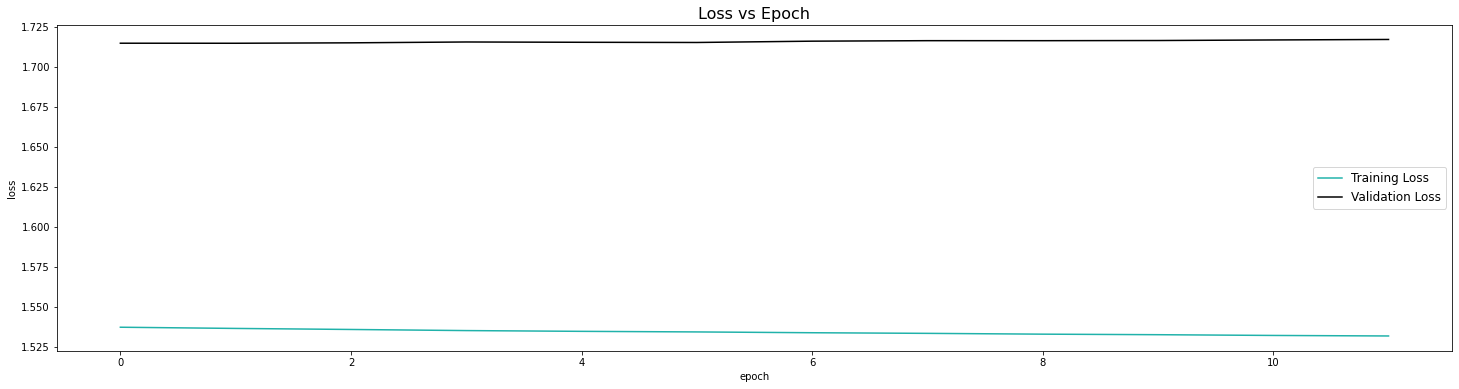

In [26]:
plt.rcParams["figure.figsize"] = [25, 6]

plt.plot(lstm_history.history['loss'], color = 'lightseagreen')
plt.plot(lstm_history.history['val_loss'], color = 'black')
plt.title('Loss vs Epoch', fontsize = 16)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='best', fontsize = 'large')
plt.show()

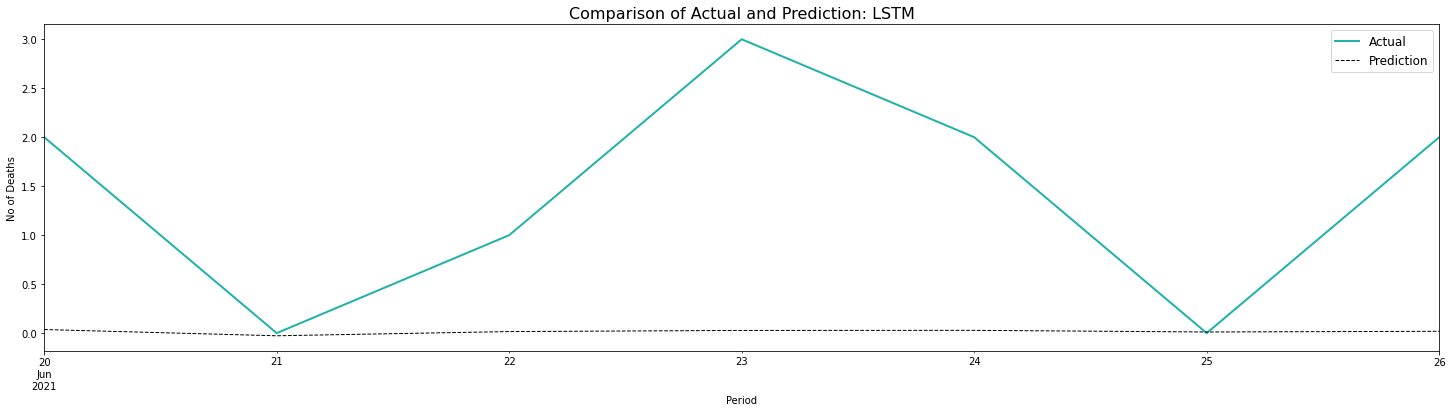

In [27]:
plt.rcParams["figure.figsize"] = [25, 6]

comparison.death_count.plot(linewidth = 2, label = 'Actual', color = 'lightseagreen')
comparison.Prediction.plot(linewidth = 1, label = 'Prediction', color = 'black', linestyle = '--')
plt.legend(fontsize = 'large')
plt.ylabel('No of Deaths')
plt.title('Comparison of Actual and Prediction: LSTM', fontsize = 16)
plt.show()

### Evaluation Metrics: Training Set

In [28]:
# Define a function to calculate MAE and RMSE
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score

errors = comparison_train['death_count'] - comparison_train['Prediction']
mse = np.square(errors).mean()
rmse = np.sqrt(mse)
mae = np.abs(errors).mean()
mape = np.abs(errors/comparison_train['death_count']).mean() * 100
r2 = r2_score(comparison_train['death_count'], comparison_train['Prediction'])

In [29]:
print('Mean Absolute Error: {:.4f}'.format(mae))
print('Root Mean Square Error: {:.4f}'.format(rmse))
print('Mean Absolute Percentage Error: {:.4f}'.format(mape))
print('R2 Score: {:.4f}'.format(r2))

Mean Absolute Error: 1.4857
Root Mean Square Error: 3.1036
Mean Absolute Percentage Error: inf
R2 Score: -0.2641


### Evaluation Metrics: Validation Set

In [30]:
# Define a function to calculate MAE and RMSE
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score

errors = comparison['death_count'] - comparison['Prediction']
mse = np.square(errors).mean()
rmse = np.sqrt(mse)
mae = np.abs(errors).mean()
mape = np.abs(errors/comparison['death_count']).mean() * 100
r2 = r2_score(comparison['death_count'], comparison['Prediction'])

In [31]:
print('Mean Absolute Error: {:.4f}'.format(mae))
print('Root Mean Square Error: {:.4f}'.format(rmse))
print('Mean Absolute Percentage Error: {:.4f}'.format(mape))
print('R2 Score: {:.4f}'.format(r2))

Mean Absolute Error: 1.4160
Root Mean Square Error: 1.7515
Mean Absolute Percentage Error: inf
R2 Score: -1.7837


## Reference

* https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/